In [20]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../utils')
from pp_utils import *

In [21]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are

subjects_to_process = ['01']

In [ ]:
#======================================================================================
#                        PARAMETERS
#======================================================================================


with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]

In [41]:
eeg_files = []

for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    print(sub_pp_dir)
    data_path = glob.glob(os.path.join(sub_pp_dir, 'eeg_error_post_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print(data_path)
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    events = data['events']

    """  already_processed = []
    already_processed.append(subject_ID)"""


    

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed/01
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed/01/eeg_error_post_01.mat


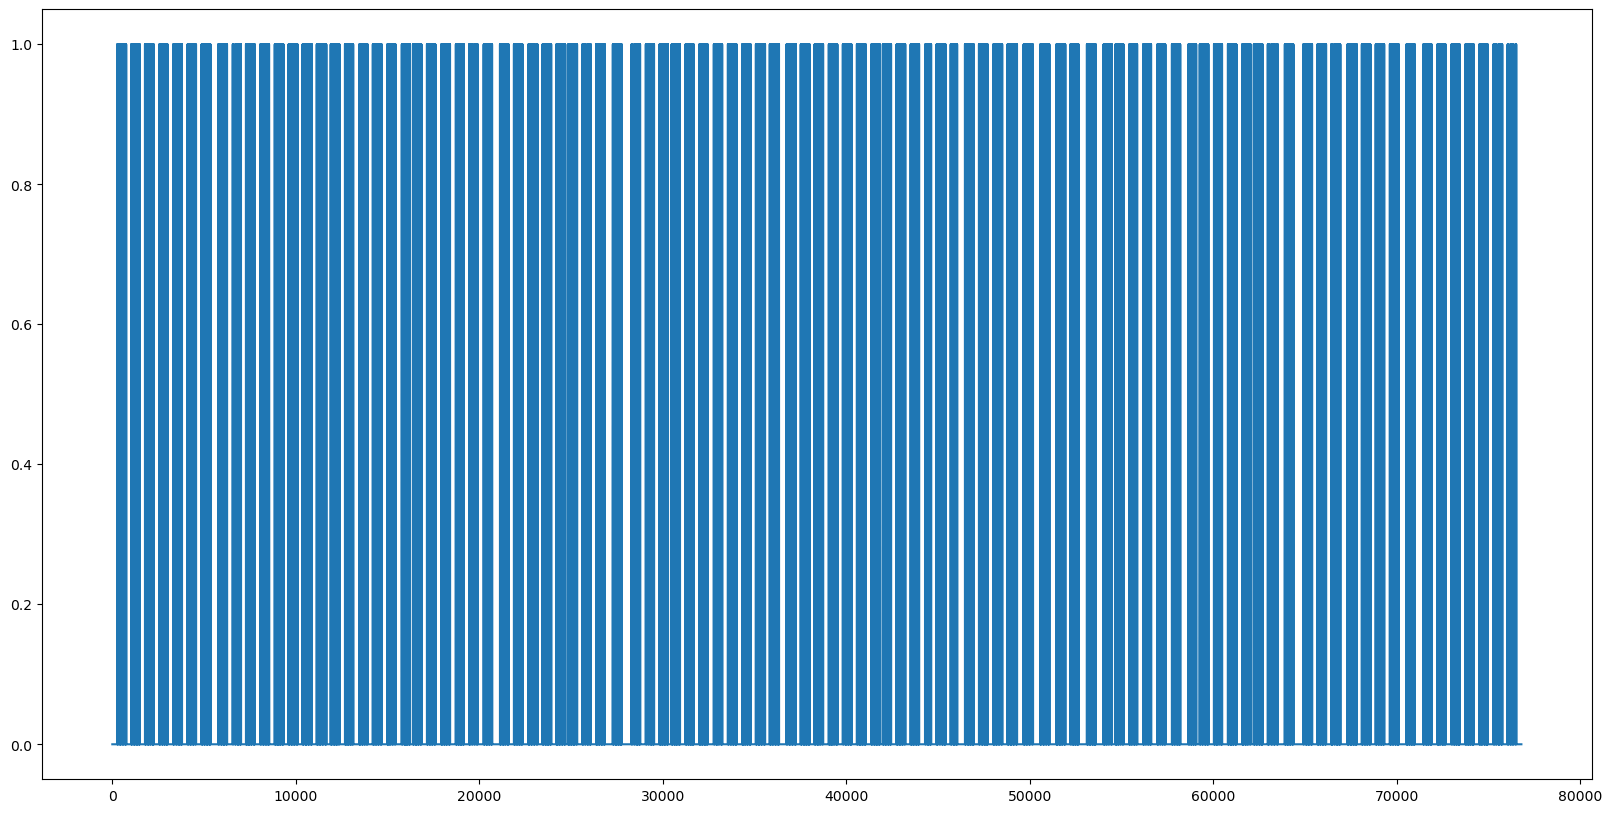

In [24]:
plt.figure(figsize = (20,10))
plt.plot(events[0])

In [36]:
info_raw = mne.create_info(ch_names=ch_names_64, sfreq = 128, ch_types='eeg')

Creating RawArray with float64 data, n_channels=64, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   599.992 secs
Ready.
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_28407/1279945632.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


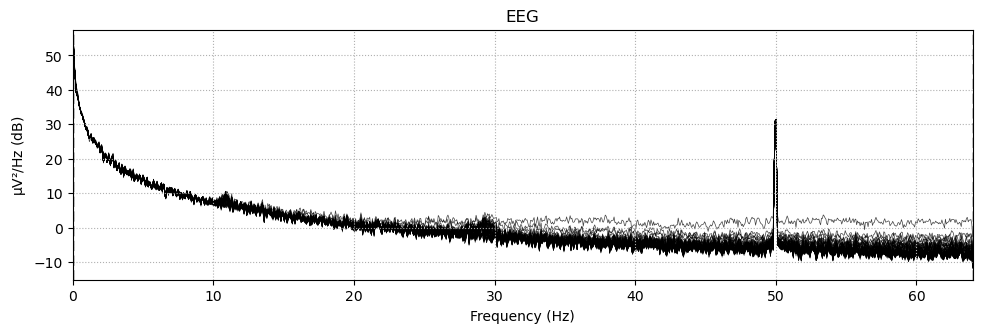

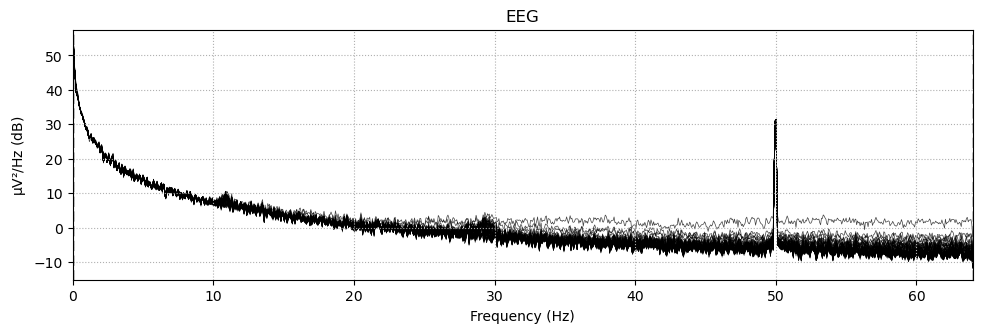

In [37]:
raw = mne.io.RawArray(eeg, info = info_raw)
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)